# Capstone Project Notebook

## IBM Data Science - Coursera

In [1]:
import pandas as pd
import numpy as np

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


---
## Segmenting and Clustering Neighborhoods in Toronto
---

### First section
---

In [3]:
# I start by reading the table to the data frame "df"
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M", header = 0)[0]
df.head(10)

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


In [4]:
# I remove the rows where the borought is Not assigned
df.drop(df[df.Borough == "Not assigned"].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
# I look for duplicates in the postal code column
duplicate = df["Postal Code"].duplicated(keep=False)
duplicate.describe()

count       103
unique        1
top       False
freq        103
Name: Postal Code, dtype: object

There are apparently no 2 rows with the same postal code in the dataframe.

In [6]:
# I assign the borough name to the neighbourhoods which are Not assigned
for i in range(0,len(df.Neighbourhood)):
               if (df.Neighbourhood[i] == "Not assigned"):
                    df.Neighbourhood[i] = df.Borough[i]

In [7]:
# I show the dimension of the resulting dataframe
df.shape

(103, 3)

***(End of the 1st section)***

---
---

### 2nd Section
---

In [8]:
# The package was mackin too many problems, so I load the csv file
location = pd.read_csv("http://cocl.us/Geospatial_data")
location.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
location.shape

(103, 3)

So both dataframes have the same number of rows as well as a common column, the Postal Code column. 

In [10]:
# I then merge both dataframes using an outer merge
toronto = pd.merge(df, location, how='outer')
toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


***(End of the section)***

---
---

### 3rd Section
---

## 1. Toronto's Neighborhood mapping

In [11]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranforming json file into a pandas dataframe library
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import folium # plotting library

In [12]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Before exploring the neighbourhoods, I want to visualize Toronto with its Boroughs.

In [13]:
# I use Folium for the map visualization
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, borough, neighbourhood in zip(toronto['Latitude'], toronto['Longitude'],\
                                            toronto['Borough'], toronto['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='cadetblue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

As suggested I will segment and cluster only boroughs that contain the word Toronto.

In [14]:
only_toronto = toronto[toronto['Borough'].str.contains('toronto', case=False, regex=False)].reset_index(drop=True)
only_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [15]:
only_toronto.Borough.groupby(only_toronto.Borough).unique()

Borough
Central Toronto      [Central Toronto]
Downtown Toronto    [Downtown Toronto]
East Toronto            [East Toronto]
West Toronto            [West Toronto]
Name: Borough, dtype: object

So there are 4 Borough containing the word 'Toronto'. So let's visualize these on the map.

In [16]:
map_toronto_center = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, borough, neighbourhood in zip(only_toronto['Latitude'], only_toronto['Longitude'],\
                                            only_toronto['Borough'], only_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='cadetblue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_center)  
    
map_toronto_center

## 2. Toronto's venues analysis

Now I will use the Foursquare API. For this I start by setting up my credentials.

In [17]:
CLIENT_ID = '1PMTYLQUAGOCHDVMVGB3ENLJUADY1QRTYGZK1FTAMBSNEJ4N' # your Foursquare ID
CLIENT_SECRET = '3MU3CON3UCSAXM3SEA4WXNZS1ZF30YSWC1J3W5VCHQQK1AVD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [18]:
# I define a function to create the get url
def built_url(neigh_lat,neigh_long,radius=500):
    LIMIT=100
    radius=500
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neigh_lat, 
    neigh_long, 
    radius, 
    LIMIT)
    return url

In [19]:
# I explore the first location
neigh_post, neigh_borough, neigh_name, neigh_lat, neigh_long = only_toronto.iloc[0]
print('Latitude and longitude of {} are {}, {}.'.format(neigh_name, 
                                                               neigh_lat, 
                                                               neigh_long))
results = requests.get(built_url(neigh_lat,neigh_long)).json()
results

Latitude and longitude of Regent Park, Harbourfront are 43.6542599, -79.3606359.


{'meta': {'code': 200, 'requestId': '5ff1c89e043dcc7790c8dc8b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 47,
  'suggestedBounds': {'ne': {'lat': 43.6587599045, 'lng': -79.3544279001486},
   'sw': {'lat': 43.6497598955, 'lng': -79.36684389985142}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'display',
 

In [20]:
# I assign relevant part of JSON to venues
venues = results['response']['groups'][0]['items']

#  and tranform venues into a dataframe
nearby_venues = json_normalize(venues)
nearby_venues

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-54ea41ad498e9a11e9e13308-0,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",54ea41ad498e9a11e9e13308,362 King St E,CA,Toronto,Canada,Trinity St,...,"[{'label': 'display', 'lat': 43.65344672305267...",43.653447,-79.362017,NaN,M5A 1K9,ON,Roselle Desserts,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-53b8466a498e83df908c3f21-1,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",53b8466a498e83df908c3f21,368 King St E,CA,Toronto,Canada,at Trinity St,...,"[{'label': 'display', 'lat': 43.65355870959944...",43.653559,-79.361809,NaN,NaN,ON,Tandem Coffee,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-574c229e498ebb5c6b257902-2,"[{'id': '52e81612bcbc57f1066b7a37', 'name': 'D...",574c229e498ebb5c6b257902,461 Cherry St,CA,Toronto,Canada,NaN,...,"[{'label': 'display', 'lat': 43.65324910177244...",43.653249,-79.358008,NaN,M5A 0H7,ON,Cooper Koo Family YMCA,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ae5b91ff964a520a6a121e3-3,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",4ae5b91ff964a520a6a121e3,457 King St. E,CA,Toronto,Canada,Gilead Place,...,"[{'label': 'display', 'lat': 43.65394694263529...",43.653947,-79.361149,NaN,M5A 1L6,ON,Morning Glory Cafe,0,[],39686393
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-50760559e4b0e8c7babe2497-4,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...",50760559e4b0e8c7babe2497,497 King Street East,CA,Toronto,Canada,btwn Sackville St and Sumach St,...,"[{'label': 'display', 'lat': 43.65473505045365...",43.654735,-79.359874,NaN,M5A 1L9,ON,Body Blitz Spa East,0,[],NaN
5,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5612b1cc498e3dd742af0dc8-5,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",5612b1cc498e3dd742af0dc8,573 King St E,CA,Toronto,Canada,at St Lawrence St,...,"[{'label': 'display', 'lat': 43.65636850543279...",43.656369,-79.356980,NaN,M5A 4L3,ON,Impact Kitchen,0,[],NaN
6,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4e8b7fa1cc2112f67517660a-6,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",4e8b7fa1cc2112f67517660a,30 Eastern Ave,CA,Toronto,Canada,Sackville St.,...,"[{'label': 'display', 'lat': 43.65331304337331...",43.653313,-79.359725,NaN,NaN,ON,The Extension Room,0,[],NaN
7,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-51ccc048498ec7792efc955e-7,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",51ccc048498ec7792efc955e,NaN,CA,NaN,Canada,NaN,...,"[{'label': 'display', 'lat': 43.65561779974973...",43.655618,-79.356211,NaN,NaN,NaN,Corktown Common,0,[],NaN
8,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad4c05ef964a520bff620e3-8,"[{'id': '4deefb944765f83613cdba6e', 'name': 'H...",4ad4c05ef964a520bff620e3,"btwn Front, Cherry, Gardiner & Parliament",CA,Toronto,Canada,NaN,...,"[{'label': 'display', 'lat': 43.65024435658077...",43.650244,-79.359323,NaN,M5A 3C4,ON,The Distillery Historic District,0,[],NaN
9,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b0978e1f964a520cd1723e3-9,"[{'id': '52f2ab2ebcbc57f1066b8b31', 'name': 'C...",4b0978e1f964a520cd1723e3,"55 Mill Street, Unit #48",CA,Toronto,Canada,The Distillery District,...,"[{'label': 'display', 'lat': 43.65062222570758...",43.650622,-79.358127,NaN,M5A 3C4,ON,SOMA chocolatemaker,0,[],NaN


In [21]:
import pandas as pd

# I extracts the category of the venue
nearby_venues['category'] = nearby_venues['venue.categories'].apply(lambda x: x[0]['name'])
    
# I keep only the columns I need
nearby_venues_filtered = nearby_venues[['venue.name', 'category', 'venue.location.neighborhood',\
                                'venue.location.postalCode', 'venue.location.lat', 'venue.location.lng']]
    
# I rename the columns for simplicity
nearby_venues_filtered.rename(columns = {'venue.name':'name', 'category':'category', \
                                     'venue.location.neighborhood':'neighbourhood',\
                                'venue.location.postalCode':'postalCode', 'venue.location.lat':'latitude', \
                                     'venue.location.lng':'longitude'}, inplace = True)

nearby_venues_filtered.head()

/Users/fclauss/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,name,category,neighbourhood,postalCode,latitude,longitude
0,Roselle Desserts,Bakery,NaN,M5A 1K9,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,NaN,NaN,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,NaN,M5A 0H7,43.653249,-79.358008
3,Morning Glory Cafe,Breakfast Spot,NaN,M5A 1L6,43.653947,-79.361149
4,Body Blitz Spa East,Spa,NaN,M5A 1L9,43.654735,-79.359874


In [22]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

47 venues were returned by Foursquare.


Now I create a function to repeat the same process for all neighbourhoods in Toronto.

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
toronto_venues = getNearbyVenues(names=only_toronto['Neighbourhood'],
                                   latitudes=only_toronto['Latitude'],
                                   longitudes=only_toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

#### Let's check the size of the resulting dataframe

In [25]:
print(toronto_venues.shape)
toronto_venues.head()

(1618, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


Let's check how many venues were returned for each neighborhood

In [26]:
toronto_venues[['Neighbourhood', 'Venue']].groupby('Neighbourhood').count()

,Venue
Neighbourhood,
Berczy Park,58
"Brockton, Parkdale Village, Exhibition Place",24
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",15
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17
Central Bay Street,65
Christie,16
Church and Wellesley,80
"Commerce Court, Victoria Hotel",100
Davisville,34


#### Let's find out how many unique categories can be curated from all the returned venues

In [27]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 232 uniques categories.


## 3. Analyze Each Neighborhood's venues

In [28]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.


In [29]:
toronto_onehot.shape

(1618, 233)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [30]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.017241,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.041667
2,"Business reply mail Processing Centre, South C...",0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0000,0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.015385,0.000000,0.000000,0.015385,0.015385
5,Christie,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.0125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012500,0.000000,...,0.0125,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.012500,0.000000,0.025000
7,"Commerce Court, Victoria Hotel",0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000
8,Davisville,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.029412,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


#### Let's confirm the new size


In [31]:
toronto_grouped.shape

(39, 233)

#### Let's print each neighborhood along with the top 5 most common venues

In [32]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.10
1        Cocktail Bar  0.05
2            Beer Bar  0.03
3      Farmers Market  0.03
4  Seafood Restaurant  0.03


----Brockton, Parkdale Village, Exhibition Place----
                venue  freq
0                Café  0.12
1              Bakery  0.08
2      Breakfast Spot  0.08
3         Coffee Shop  0.08
4  Italian Restaurant  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Gym / Fitness Center  0.07
1            Restaurant  0.07
2            Skate Park  0.07
3  Fast Food Restaurant  0.07
4         Burrito Place  0.07


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.18
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3             Plane  0.06
4     Boat or Ferry  0.06


----Central Bay Street----
            

#### Let's put that into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [123]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Beer Bar,Farmers Market,Restaurant,Seafood Restaurant,Park,Beach
1,"Brockton, Parkdale Village, Exhibition Place",Café,Bakery,Breakfast Spot,Coffee Shop,Yoga Studio,Grocery Store,Pet Store,Performing Arts Venue,Nightclub,Italian Restaurant
2,"Business reply mail Processing Centre, South C...",Skate Park,Garden Center,Burrito Place,Fast Food Restaurant,Farmers Market,Spa,Light Rail Station,Restaurant,Garden,Pizza Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Plane,Sculpture Garden
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Salad Place,Bubble Tea Shop,Burger Joint,Thai Restaurant,Yoga Studio,Modern European Restaurant


## 4. Cluster Neighborhoods

Run _k_-means to cluster the neighborhood into clusters. First let's find out how many clusters would be appropriate.

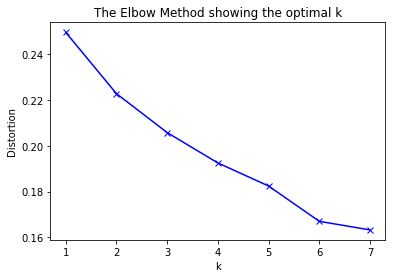

In [134]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood',1)

# k means determine k
distortions = []
K = range(1,8)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'),\
                                  axis=1)) / toronto_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

According to the Elbow method the optimal k seems to be is 3.

In [124]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [125]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = only_toronto

# merge toronto_grouped with only_toronto to add latitude/longitude for each neighbourhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Park,Bakery,Café,Pub,Breakfast Spot,Restaurant,Theater,Cosmetics Shop,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Sushi Restaurant,Yoga Studio,Discount Store,Park,Music Venue,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Hobby Shop
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Japanese Restaurant,Hotel,Middle Eastern Restaurant,Cosmetics Shop,Theater,Fast Food Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,American Restaurant,Gastropub,Cocktail Bar,Cheese Shop,Park,Moroccan Restaurant,Cosmetics Shop,Gym
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pizza Place,Asian Restaurant,Trail,Health Food Store,Pub,Neighborhood,Yoga Studio,Distribution Center,Dessert Shop,Diner


Finally, let's visualize the resulting clusters

In [137]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], \
                                  toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster +1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's examine the resulting clusters

#### Cluster 1

In [127]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,East Toronto,0,Pizza Place,Asian Restaurant,Trail,Health Food Store,Pub,Neighborhood,Yoga Studio,Distribution Center,Dessert Shop,Diner
18,Central Toronto,0,Park,Bus Line,Business Service,Swim School,Falafel Restaurant,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop
21,Central Toronto,0,Park,Trail,Jewelry Store,Sushi Restaurant,Department Store,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop
29,Central Toronto,0,Restaurant,Tennis Court,Trail,Playground,Distribution Center,Department Store,Dessert Shop,Diner,Discount Store,Yoga Studio
33,Downtown Toronto,0,Park,Playground,Trail,Deli / Bodega,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


The neighbourhoods from the first cluster have Trail and Park or Playground in common in their top 3.

#### Cluster 2

In [128]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,1,Garden,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


Very diverse venues in this neighbourhood, placing it alone in a cluster.

#### Cluster 3

In [129]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,2,Coffee Shop,Park,Bakery,Café,Pub,Breakfast Spot,Restaurant,Theater,Cosmetics Shop,Shoe Store
1,Downtown Toronto,2,Coffee Shop,Sushi Restaurant,Yoga Studio,Discount Store,Park,Music Venue,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Hobby Shop
2,Downtown Toronto,2,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Japanese Restaurant,Hotel,Middle Eastern Restaurant,Cosmetics Shop,Theater,Fast Food Restaurant
3,Downtown Toronto,2,Coffee Shop,Café,American Restaurant,Gastropub,Cocktail Bar,Cheese Shop,Park,Moroccan Restaurant,Cosmetics Shop,Gym
5,Downtown Toronto,2,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Beer Bar,Farmers Market,Restaurant,Seafood Restaurant,Park,Beach
6,Downtown Toronto,2,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Salad Place,Bubble Tea Shop,Burger Joint,Thai Restaurant,Yoga Studio,Modern European Restaurant
7,Downtown Toronto,2,Grocery Store,Café,Park,Italian Restaurant,Restaurant,Baby Store,Athletics & Sports,Nightclub,Coffee Shop,Candy Store
8,Downtown Toronto,2,Coffee Shop,Café,Restaurant,Hotel,Gym,Thai Restaurant,Deli / Bodega,Sushi Restaurant,Burrito Place,Salad Place
9,West Toronto,2,Bakery,Pharmacy,Brewery,Music Venue,Supermarket,Middle Eastern Restaurant,Café,Pool,Bar,Playground
10,Downtown Toronto,2,Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Scenic Lookout,Restaurant,Brewery,Italian Restaurant,History Museum


It the largest cluster with 38 neighbourhoods, all of which are very "food and drink-oriented" with at least 5 venues out of the top 10. For example 26 out of the 38 have a coffee shop, 37 have a restaurant of similar.

---
---

## 5. Summary


In this analysis, I had a look at the city of Toronto and in particular the "city center" (all neighbourhoods containing the name "Toronto". 
Then I had a look at the venues for these neighbourhoods. The categories of the 10 most common venues for each neighbourhood was extracted from the Foursquare API.
Finally, I clustered the neighbourhoods according to the most common venue categories.